In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
# function recycled from capstone 1 used in part 3. 
def classifier_analysis(clf, xt, yt):
    ''' Predict and measure quality of model with a variety of metrics.   

    Parameters
    ----------

    xt : ndarray or DataFrame (n_samples, n_features)
             Feature data to test. n_features represents the number of features
             present in the data used to train the estimator clf

    yt : ndarray (n_samples, )
             Target data to test. 


    clf : scikit-learn estimator which has been fit to data with same number of columns as X_test

    '''
    y_predict = clf.predict(xt)
    y_predict_proba= clf.predict_proba(xt)[:,1]

    cm = confusion_matrix(yt, y_predict, labels=[0,1])#,dtype=float)
    # negative guesses
#     cm[:, 0] = cm[:, 0] / (len(yt) - yt.sum())
#     cm[:, 1] = cm[:, 1] / yt.sum()
    print('tn, fp, fn, tp', cm.ravel())
    _ = ConfusionMatrixDisplay(cm / (yt.size), [0,1]).plot()
    
    print(classification_report(yt, y_predict))

    roc_auc = roc_auc_score(yt, y_predict_proba)
    fpr, tpr, thresholds = roc_curve(yt, y_predict_proba)

    plt.figure()
    plt.plot(fpr, tpr, label=(clf.__class__.__name__ + '(area = %0.2f)' % roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    average_precision = average_precision_score(yt, y_predict_proba)
    precision, recall, thresholds = precision_recall_curve(yt, y_predict_proba)
    disp = plot_precision_recall_curve(clf, xt, yt)
    disp.ax_.set_ylim([0.0, 1.0])
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    plt.show()
    
    return roc_auc

## Task:

Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven-day  period ,  identify  which  factors  predict  future  user
adoption.

We  suggest  spending  1-2  hours  on  this,  but  you're  welcome  to  spend  more  or  less.
Please  send  us  a  brief  writeup  of  your  findings  (the  more  concise,  the  better -- no  more
than  one  page),  along  with  any  summary  tables,  graphs,  code,  or  queries  that  can  help
us  understand  your  approach.  Please  note  any  factors  you  considered  or  investigation
you  did,  even  if  they  did  not  pan  out.  Feel  free  to  identify  any  further  research  or  data
you  think  would  be  valuable.

In [3]:
# Default encoding throws an error
users_df = pd.read_csv('takehome_users.csv', encoding="ISO-8859-1")
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


    ● name:  the  user's  name
    ● object_id:   the  user's  id
    ● email:  email  address
    ● creation_source:   how  their  account  was  created.  This  takes  on  one
    of  5  values:
    ○ PERSONAL_PROJECTS:  invited  to  join  another  user's
    personal  workspace
    ○ GUEST_INVITE:  invited  to  an  organization  as  a  guest
    (limited  permissions)
    ○ ORG_INVITE:  invited  to  an  organization  (as  a  full  member)
    ○ SIGNUP:  signed  up  via  the  website
    ○ SIGNUP_GOOGLE_AUTH:  signed  up  using  Google
    Authentication  (using  a  Google  email  account  for  their  login
    id)
    ● creation_time:  when  they  created  their  account
    ● last_session_creation_time:   unix  timestamp  of  last  login
    ● opted_in_to_mailing_list:  whether  they  have  opted  into  receiving
    marketing  emails
    ● enabled_for_marketing_drip:  whether  they  are  on  the  regular
    marketing  email  drip
    ● org_id:   the  organization  (group  of  users)  they  belong  to
    ● invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).


The user_id in engagement_df is equivalent to object_id in users_df. Change this to user_id for consistency.

In [4]:
users_df.columns = ['user_id'] + users_df.columns.tolist()[1:]

In [5]:
users_df.isna().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

Creation time and last_session_creation_time use different conventions for specifying the current time. The first thing I want to do is make these consistent. The presence of missing values makes this more difficult however. The last_session_creation_time feature is of the form of timestamps, but creation_time is of UTC format. I will fill the missing last_session_creation_time values with the corresponding creation_time values as timestamps, as I believe this is an indication that the user never logged in; meaning that their last interaction was during account creation. These timestamps will then be converted to UTC en masse.


In [6]:
missing_last_login_index = users_df[users_df.last_session_creation_time.isna()].index

In [7]:
creation_datetime = pd.to_datetime(users_df.creation_time)
creation_timestamp = creation_datetime.apply(datetime.datetime.timestamp)

In [8]:
users_df.loc[missing_last_login_index, 'last_session_creation_time'] =  \
creation_timestamp.loc[missing_last_login_index].values

In [9]:
users_df.isna().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [10]:
# Convert string to utc datetime
users_df.loc[:, 'creation_time'] = creation_datetime.values

# convert timestamps to utc datetime
users_df.loc[:, 'last_session_creation_time'] = \
users_df.loc[:, 'last_session_creation_time'].apply(datetime.datetime.utcfromtimestamp)

# users_df.loc[:, 'invited_by_user_id'] = users_df.loc[:, 'invited_by_user_id'].fillna(0).values
users_df.loc[users_df[users_df.invited_by_user_id!=0].index,'invited_by_user_id'] = 1

In [11]:
engagement_df = pd.read_csv('takehome_user_engagement.csv')
engagement_df = engagement_df.sort_values(by=['user_id','time_stamp'])
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [12]:
engagement_df.loc[:, 'time_stamp'] = pd.to_datetime(engagement_df.time_stamp).values

The last act of cleaning that I believe I need is to account for the non-referral instances, i.e. missing values in ```invited_by_user_id``` column. Because the user_id values are numeric, I'll use a placeholder of -1. 

The first main course of action is to, of course, define the which users adopted or not. To do this, I need some way of calculating the number of logins in a seven day period; note that a 7-day period is different from calendar week. First, we can eliminate those who have never logged in, or in fact, those who have never logged in 3 times even.

In [13]:
users = set(users_df.user_id.values)#.unique()
users_with_login = set(engagement_df.user_id.values)
users_no_login = users - users_with_login
login_count = engagement_df.groupby('user_id').sum()
users_less_than3_login = set(login_count[login_count.visited<3].index)
users_possibly_adopted = set(login_count[login_count.visited>=3].index)
# set().intersection(set(engagement_df.user_id.unique()))

In [14]:
adopt_df = engagement_df[engagement_df.user_id.isin(users_possibly_adopted)]

Because the 7-day windows are defined based on the dates themselves, simply create a new feature called ```time_stamp_plus_7```

In [15]:
(adopt_df.loc[:, 'time_stamp'].values + pd.Timedelta(days=7)).shape

(201002,)

In [16]:
(adopt_df.loc[:, 'time_stamp'] + pd.Timedelta(days=7)).to_frame(name='time_stamp_plus_7')

,time_stamp_plus_7
1,2013-11-22 03:45:04
2,2013-12-06 03:45:04
3,2013-12-16 03:45:04
4,2014-01-01 03:45:04
5,2014-01-07 03:45:04
...,...
207905,2014-04-27 14:22:45
207906,2014-05-02 14:22:45
207907,2014-05-05 14:22:45
207908,2014-05-24 14:22:45


In [17]:
adopt_df = pd.concat((adopt_df, (adopt_df.loc[:, 'time_stamp'] 
                      + pd.Timedelta(days=7)).to_frame(name='time_stamp_plus_7')),axis=1)

Iterate over the different ```time_stamp``` values for each user. 

In [18]:
adopted_users = []
for u in adopt_df.user_id.unique():
    # slice out a single user at a time.
    single_user_engagement_df = adopt_df[adopt_df.user_id==u]
    
    #iterate over this DataFrame slice
    for row_index in single_user_engagement_df.index:
        # choose the endpoints of the 7 day window
        start = single_user_engagement_df.time_stamp
        end = single_user_engagement_df.time_stamp_plus_7
        # Count how many times the user logged in, in the present time + 7 days.
        count_7day = len(single_user_engagement_df[(single_user_engagement_df.time_stamp>=start)
                                      &(single_user_engagement_df.time_stamp<=end)])
        if count_7day >= 3:
            adopted_users.append(single_user_engagement_df.user_id.unique().tolist()[0])
            # if we identified the user as adopted, can skip the remaining calculations.
            break

Now we can use the adopted users, we can setup the dependent variable for the modeling process.

In [19]:
users_df.loc[:, 'adopted'] = 0 
users_df.loc[users_df[users_df.user_id.isin(adopted_users)].index,'adopted'] = 1

For modeling purposes, the categorical variables with unique values per user are discarded from the modeling process. Alternatives could use NLP for the encoding of name and emails. To fairly weight the org id's they need to be encoded. 

I'm going to convert invited by user id to a binary flag column.

For datetime variables, use a binning algorithm to encode.

In [20]:
users_df.sample(5)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
9870,9871,2013-06-05 14:24:05,Glockner Kathrin,KathrinGlockner@yahoo.com,ORG_INVITE,2013-06-05 18:24:05,1,1,42,1.0,0
10432,10433,2014-05-09 20:37:24,Pereira Bruno,BrunoDiasPereira@hotmail.com,GUEST_INVITE,2014-05-30 20:37:24,0,0,87,1.0,1
6809,6810,2013-11-14 18:18:28,Muller Bernd,BerndMuller@jourrapide.com,ORG_INVITE,2014-05-27 18:18:28,0,0,137,1.0,1
3786,3787,2013-02-26 20:39:17,Vidler Flynn,FlynnVidler@gmail.com,ORG_INVITE,2013-02-27 20:39:17,0,0,196,1.0,0
2505,2506,2014-03-14 19:56:54,Duffy Anna,AnnaDuffy@gmail.com,SIGNUP_GOOGLE_AUTH,2014-03-15 19:56:54,0,0,64,1.0,0


In [21]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, plot_precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.metrics import average_precision_score, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA, SparsePCA 
from sklearn.linear_model import LogisticRegression

y = users_df.adopted.values
model_df = users_df.drop(columns=['adopted','user_id','name','email','org_id'])

In [22]:
model_df.nunique()

creation_time                 11996
creation_source                   5
last_session_creation_time    11997
opted_in_to_mailing_list          2
enabled_for_marketing_drip        2
invited_by_user_id                1
dtype: int64

Bin the times, encode the other categoricals

In [23]:
kbin = KBinsDiscretizer()
binned_times = (kbin.fit_transform(
                                    (model_df.loc[:, ['creation_time','last_session_creation_time']]
                                    ).applymap(datetime.datetime.timestamp)
                                  )
               ).toarray()

cat_dummies = pd.get_dummies(model_df.loc[:, ['creation_source']], drop_first=True).values


First remove the original features and then add back their encodings. 

In [24]:
Xtmp = model_df.drop(columns=['creation_source','creation_time','last_session_creation_time'])
X = np.concatenate((Xtmp.values, binned_times, cat_dummies),axis=1)

I want to include the numerical data on the total number of logins, but this is related to the dependent variable and so it is not allowed. All of the columns of X are binary, therefore I don't think rescaling is necessary.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Feature selection

I just want to make a very obvious but simple observation that with org_id encoded included, there are 433 columns; without there are only 17. I choose to go without, for this exercise.

tn, fp, fn, tp [1781  157  142  320]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1938
           1       0.67      0.69      0.68       462

    accuracy                           0.88      2400
   macro avg       0.80      0.81      0.80      2400
weighted avg       0.88      0.88      0.88      2400



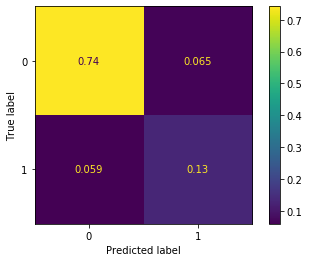

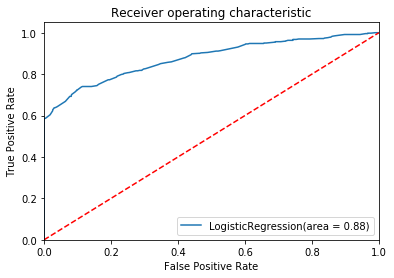

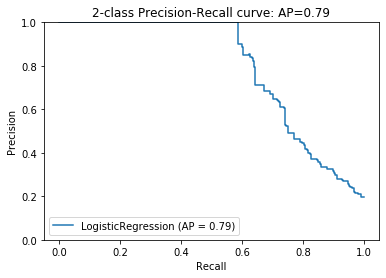

In [26]:
logistic_regression = LogisticRegression(class_weight='balanced')
_ = logistic_regression.fit(X_train, y_train)
logreg_roc_auc_test = classifier_analysis(logistic_regression, X_test, y_test)

tn, fp, fn, tp [1938    0  209  253]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1938
           1       1.00      0.55      0.71       462

    accuracy                           0.91      2400
   macro avg       0.95      0.77      0.83      2400
weighted avg       0.92      0.91      0.90      2400



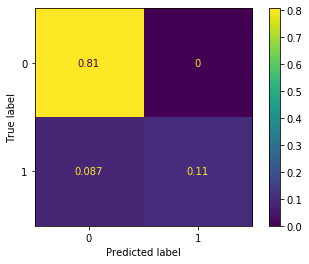

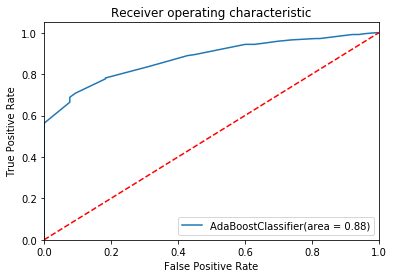

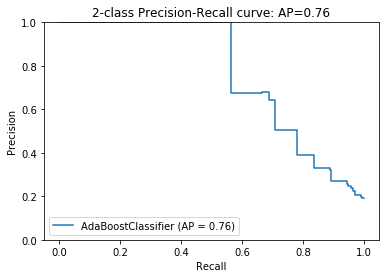

In [27]:
ada_boost = AdaBoostClassifier()
_ = ada_boost.fit(X_train, y_train)
adaboost_roc_auc_test = classifier_analysis(ada_boost, X_test, y_test)

tn, fp, fn, tp [1936    2  189  273]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1938
           1       0.99      0.59      0.74       462

    accuracy                           0.92      2400
   macro avg       0.95      0.79      0.85      2400
weighted avg       0.93      0.92      0.91      2400



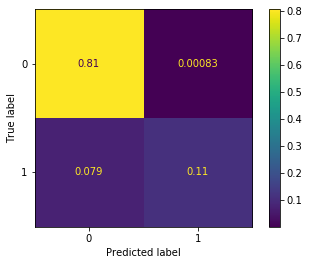

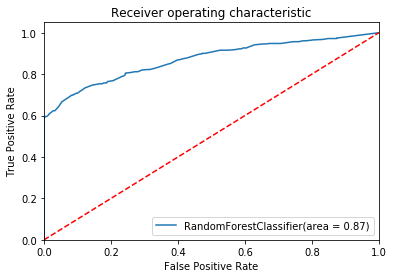

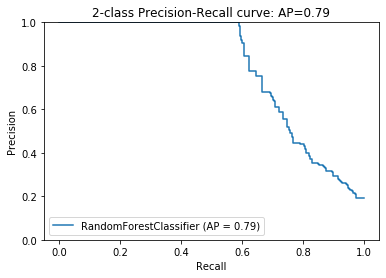

In [28]:
random_forest = RandomForestClassifier()
_ = random_forest.fit(X_train, y_train)
ranfor_roc_auc_test = classifier_analysis(random_forest, X_test, y_test)

tn, fp, fn, tp [1938    0  189  273]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1938
           1       1.00      0.59      0.74       462

    accuracy                           0.92      2400
   macro avg       0.96      0.80      0.85      2400
weighted avg       0.93      0.92      0.91      2400



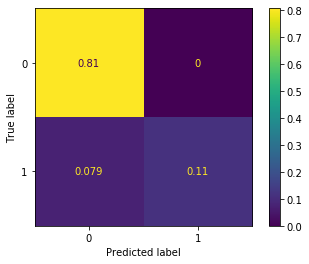

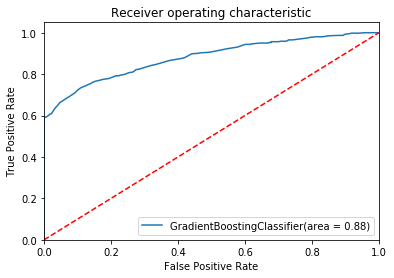

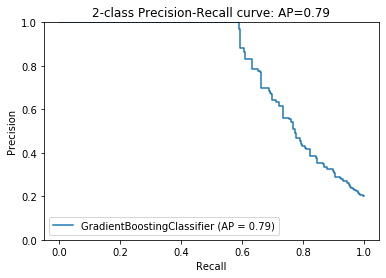

In [29]:
gradient_boost = GradientBoostingClassifier()
_ = gradient_boost.fit(X_train, y_train)
gradboost_roc_auc_test = classifier_analysis(gradient_boost, X_test, y_test)

LogisticRegression and GradientBoostingClassifier have similar ROC_AUC scores, but the f1-score for the adopted users is better with respect to the GradientBoostingClassifier and so this is what I would likely recommend, as predicting whether or not a user will adopt is the entire goal. Can look at the feature importances using the corresponding attribute of GradientBoostingClassifier

In [30]:
gradient_boost.feature_importances_

array([1.89541425e-04, 6.23269124e-04, 0.00000000e+00, 3.37513877e-02,
       6.20603733e-03, 1.45859012e-02, 1.92819037e-03, 3.73667609e-01,
       2.41414613e-02, 2.90148467e-03, 2.45781949e-02, 2.18296576e-02,
       4.88473251e-01, 9.81554038e-04, 5.23353900e-03, 7.69959003e-04,
       1.38962333e-04])

In [31]:
f_importance = np.argsort(gradient_boost.feature_importances_)[::-1]
f_importance

array([12,  7,  3, 10,  8, 11,  5,  4, 14,  9,  6, 13, 15,  1,  0, 16,  2],
      dtype=int64)

Note that features 0,1,2 are the columns ```['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'invited_by_user_id']```

Features indexed from 3 to 7 are bins of the ```creation_times```

Features indexed from 8 to 12 are bins of ```last_session_creation_time```.

Features indexed from 13 to 16 are one-hot columns for ```creation_source```.

Note that the binning strategy used on the time columns indicates that higher values (more recent times) are in the higher-indexed bins. Therefore it looks like it is important how recent the user both created and last logged into the service are important as these account for the two most important features. I think that the most recent login time makes sense because if a user has adopted the service then they'll likely be using it. I don't know why creation time would matter, however. 

With the types of data used (I could re-add the organization ID's) it is hard to provide a recommendation other than perhaps to focus on attracting new users rather than older users. One reason for this is perhaps the service has been updated over time and is better now than it was before.